## 0.1 Vanilla DQN Architecture

### 0.1.1 Import Required Libraries

In [1]:
import math, random, time

import gym
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set PyTorch Device for tensors
device = "cuda" if torch.cuda.is_available() else "cpu"

### 0.1.2 Define Basic Replay Buffer Implementation

In [3]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    # Append new experience tuple to replay buffer
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    # Select experience from replay buffer
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

### 0.1.3 Create Lamba Function for Epsilon Greedy Strategy

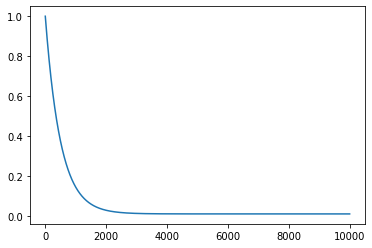

In [4]:
# Hyperparameters for epsilon greedy strategy
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

# Function computes current exploration rate for given frame
epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

plt.plot([epsilon_by_frame(i) for i in range(10000)])

### 0.1.4 Build Classes for DQN

In [5]:
class DQN(nn.Module):
    # DQN follows typical feedforward neural network architecture
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    # Choose action using epsilon greedy strategy: choose random action with probability epsilon
    def choose_action(self, state, epsilon):
        if random.random() > epsilon:
            state   = torch.FloatTensor(state).unsqueeze(0)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action

### 0.1.5 Build Functions for Computing Temporal Difference Loss

In [6]:
def compute_td_loss(batch_size):
    # Loss here is calculated as the MSE between the current Q-value and next Q-values
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(np.float32(state))
    next_state = torch.FloatTensor(np.float32(next_state))
    action     = torch.LongTensor(action)
    reward     = torch.FloatTensor(reward)
    done       = torch.FloatTensor(done)

    q_values      = model(state)
    next_q_values = model(next_state)

    # Select next action which maximises reward
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    # Calculate MSE
    loss = (q_value - expected_q_value.data).pow(2).mean()

    # Update network
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss



### 0.1.6 Helper Function for Plotting Rewards & Loss

In [7]:
def plot(frame_idx, rewards, losses):
    # Clear previous output from the notebook
    clear_output(True)
    plt.figure(figsize=(20,5), )
    ax1 = plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    # Plot rewards
    plt.plot(rewards)
    ax2 = plt.subplot(132)
    plt.title('loss')
    # Plot losses
    plt.plot(losses)
    plt.savefig('../charts/dqn_plot.png')
    plt.show()

### 0.1.7 Train DQN and Save Model at Various Periods

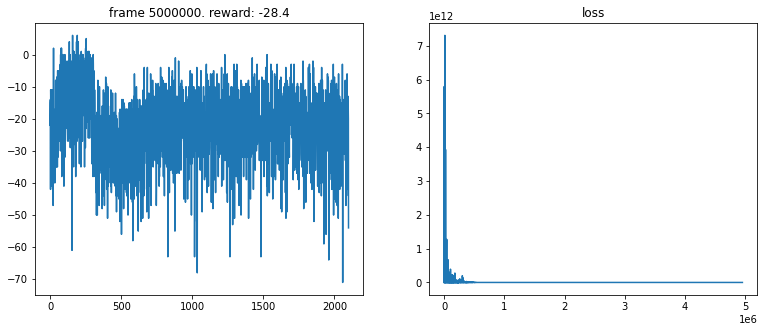

Percentage of Frames Complete: 100.00


In [8]:
# Hyperparameters
num_frames = 5e6
model_save_frames  = [1e4, 1e5, 2.5e5, 5e5, 1e6, 2e6, 3e6, 4e6, 5e6]
batch_size = 64
pre_warm_memory_size   = 5e4
gamma = 0.99
buffer_size = int(1e6)

# Variables to keep track of frame losses, episode rewards, and current episode reward
losses = []
all_rewards = []
episode_reward = 0

# Initialise environmnet
env_id = "Boxing-ram-v0"
env = gym.make(env_id)

state = env.reset()

# Create DQN model
model = DQN(env.observation_space.shape[0], env.action_space.n).to(device)

# Set optimiser
optimizer = optim.Adam(model.parameters())

# Set replay buffer
replay_buffer = ReplayBuffer(buffer_size)

# Define training loop
for frame_idx in range(1, int(num_frames) + 1):

    # Calculate epsilon value to determine explore/exploit
    epsilon = epsilon_by_frame(frame_idx)
    # Select action using DQN
    action = model.choose_action(state, epsilon)
    
    # Move through environment based on the selected action
    next_state, reward, done, _ = env.step(action)
    # Store transition in replay memory
    replay_buffer.push(state, action, reward, next_state, done)

    # Get next state
    state = next_state
    # Keep track of total reward by episode
    episode_reward += reward
    
    # If the latest action ended the episode, reset as required
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0

    # If the buffer is big enough, propagate through DQN
    if len(replay_buffer) > pre_warm_memory_size:
        # Calulate network loss
        loss = compute_td_loss(batch_size)
        
        # Handle instances where loss is empty
        try:
            losses.append(loss.data[0])
        except IndexError:
            losses.append(loss.item())
    
    # Save and plot training metrics
    if frame_idx % 2000 == 0:
        plot(frame_idx, all_rewards, losses)
        print("Percentage of Frames Complete: {:.2f}".format(100 * frame_idx / num_frames))
        
        rewards_df = pd.DataFrame({'rewards': all_rewards})
        losses_df = pd.DataFrame({'losses': losses})
        
        rewards_df.to_csv('../output/rewards/boxing_dqn.csv', index=False)
        losses_df.to_csv('../output/losses/boxing_dqn.csv', index=False)

    # Save models
    if frame_idx in model_save_frames:
        torch.save(model, "../models/dqn_%s_%s.model" % (env_id, frame_idx))